## Introduction
In this notebook, I will go through a personal project where I created a model predicting 4 month changes in stock price.  Next, I will compare stock picks from my model with the S&P 500.  For example, if Microsoft rises 14% over 4 months and SPY rises 10%, the metric "spy_month_80" is measuring the 4% difference.

## Data Preprocessing
Previously, I obtained stock prices from yfinance and financial statements from alpha vantage.  I cleaned and transformed this data and imported it into a PostgreSQL database.

## Models
I split the data into training, validation, and testing sets by year.  I ran the data through linear regression, random forest, and lightGBM with the latest doing the best.

## Results
After binning the predictions, there was a strong correlation between actual and predicted stock prices.  Likewise, stocks with high predicted scores outperformed the S&P 500 index.

In [6]:
import pandas as pd
from datetime import date, timedelta, datetime
import yfinance as yf
import alpha_vantage
import requests
from sqlalchemy import create_engine
from functions_20210101_months import *
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

engine = create_engine('postgresql://postgres@localhost:5432/etf')

stock_df = pd.read_sql_query("""
select
*
from 
train_table_months
where
month between '2012-01-01' and '2021-05-01'
""",con=engine)

stock_df.drop_duplicates(inplace=True)

In [7]:
stock_df['totalRevenue'] = stock_df['totalRevenue'].fillna(0).astype('float')
stock_df['netIncome_x'] = stock_df['netIncome_x'].fillna(0).astype('float')

stock_df = stock_df[(stock_df.totalRevenue != 0) & (stock_df.netIncome_x != 0) & ~(stock_df.totalRevenue.isnull()) & ~(stock_df.netIncome_x.isnull())]

In [8]:
stock_df = stock_df.fillna(0)
stock_df = stock_df[stock_df['spy_month_80'] < 10]
stock_df = stock_df[stock_df['spy_month_80'] > -10]
stock_df = stock_df[stock_df['Open'] >= 1]
stock_df = stock_df.loc[(stock_df['month_-120'] > stock_df['month_-120'].mean() - 3 * stock_df['month_-120'].std() ) & (stock_df['month_-120'] < stock_df['month_-120'].mean() + 3 * stock_df['month_-120'].std() )]
stock_df['estimatedEPS'] = stock_df['estimatedEPS'].astype(float)
stock_df = stock_df.loc[(stock_df['estimatedEPS'] > stock_df['estimatedEPS'].mean() - 3 * stock_df['estimatedEPS'].std() ) & (stock_df['estimatedEPS'] < stock_df['estimatedEPS'].mean() + 3 * stock_df['estimatedEPS'].std() )]
stock_df['reportedEPS'] = stock_df['reportedEPS'].astype(float)
stock_df = stock_df.loc[(stock_df['reportedEPS'] > stock_df['reportedEPS'].mean() - 3 * stock_df['reportedEPS'].std() ) & (stock_df['reportedEPS'] < stock_df['reportedEPS'].mean() + 3 * stock_df['reportedEPS'].std() )]

In [9]:
X_train = stock_df[stock_df.month <= '2018-05-01'].drop(columns = ['stock', 'month', 'spy_month_20', 'spy_month_40', 'spy_month_60', 'spy_month_80', 'spy_month_120', 'spy_month_240', 'month_20', 'month_40', 'month_60', 'month_80', 'month_120', 'month_240'])
X_train = X_train.apply(pd.to_numeric)

y_train = stock_df.loc[stock_df.month <= '2018-05-01', 'spy_month_80'].copy()

X_test = stock_df[stock_df.month >= '2018-06-01'].drop(columns = ['stock', 'month', 'spy_month_20', 'spy_month_40', 'spy_month_60', 'spy_month_80', 'spy_month_120', 'spy_month_240', 'month_20', 'month_40', 'month_60', 'month_80', 'month_120', 'month_240'])
X_test = X_test.apply(pd.to_numeric)

y_test = stock_df.loc[stock_df.month >= '2018-06-01'].copy()

In [10]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=0)
random_forest_model = regr.fit(X_train, y_train)

y_test['forest_predict'] = random_forest_model.predict(X_test)
print('mse', mean_squared_error(y_test['spy_month_80'], y_test['forest_predict']) )
print('r2', r2_score(y_test['spy_month_80'], y_test['forest_predict']) )

C:\Users\david\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


mse 0.15243108139119768
r2 -0.11727121783751548


In [11]:
# parameters = {
#     'boosting':['gbdt', 'dart']
#     , 'learning_rate':[.09, .1, .11]
#     , 'n_estimators':[80,100,120]}
# gs_lightgbm_model = GridSearchCV(lgb.LGBMRegressor(), parameters, scoring='neg_mean_squared_error')
# gs_lightgbm_model.fit(X_train, y_train)
# gs_lightgbm_model.best_params_

In [12]:
# Use tuned parameters to train final model

# lightgbm_model = lgb.LGBMRegressor(**gs_lightgbm_model.best_params_).fit(X_train, y_train)
lightgbm_model = lgb.LGBMRegressor().fit(X_train, y_train)

y_test['lightgbm_predict_80'] = lightgbm_model.predict(X_test)
print('mse', mean_squared_error(y_test['spy_month_80'], y_test['lightgbm_predict_80']) )
print('r2', r2_score(y_test['spy_month_80'], y_test['lightgbm_predict_80']) )

mse 0.13489913298572787
r2 0.011232373210122715


In [13]:
y_test[['month', 'stock', 'spy_month_80', 'lightgbm_predict_80']].rename(columns={'stock': 'Stock', 'month':'Month', 'lightgbm_predict_80':'Predictions', 'spy_month_80':'Actual'}).sort_values('Predictions', ascending=False).head(10)

,Month,Stock,Actual,Predictions
88910,2020-03-01,SM,1.932940,1.868861
45400,2018-12-01,NVFY,0.713273,1.649515
84978,2020-02-01,TUP,0.494006,1.640240
94201,2020-05-01,RRD,0.048594,1.607728
67242,2019-08-01,NLS,0.152259,1.598074
87949,2020-03-01,TUP,4.207254,1.597892
105206,2020-08-01,EXPR,-0.078233,1.552565
75998,2019-11-01,PRTY,-0.478836,1.388119
102187,2020-07-01,EXPR,-0.065588,1.381189
112258,2020-11-01,RRD,1.943402,1.364806


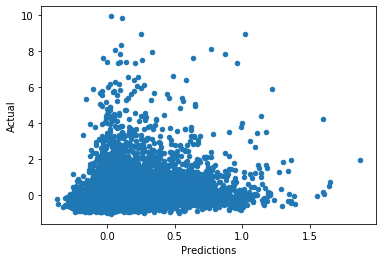

In [14]:
y_test.rename(columns={'lightgbm_predict_80':'Predictions', 'spy_month_80':'Actual'}).plot.scatter(x = 'Predictions', y = 'Actual')

mse 0.00211269687798154
r2 0.4144504443757753


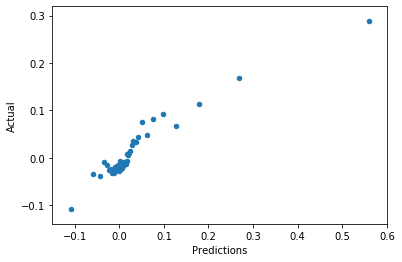

In [15]:
# bin predictions into 99 groups and plot average predictions vs actuals

y_test['lightgbm_binned'] = pd.qcut(y_test['lightgbm_predict_80'], q=50)
light_df = y_test.groupby(['lightgbm_binned']).agg({'lightgbm_predict_80' : 'mean', 'spy_month_80' : 'mean', 'Open' : 'count'})
light_df.rename(columns={"lightgbm_predict_80": "Predictions", "spy_month_80": "Actual"}, inplace=True)
light_df.plot.scatter(x = 'Predictions', y = 'Actual')
print('mse', mean_squared_error(light_df['Actual'], light_df['Predictions']) )
print('r2', r2_score(light_df['Actual'], light_df['Predictions']) )

(8.0, 0.0)

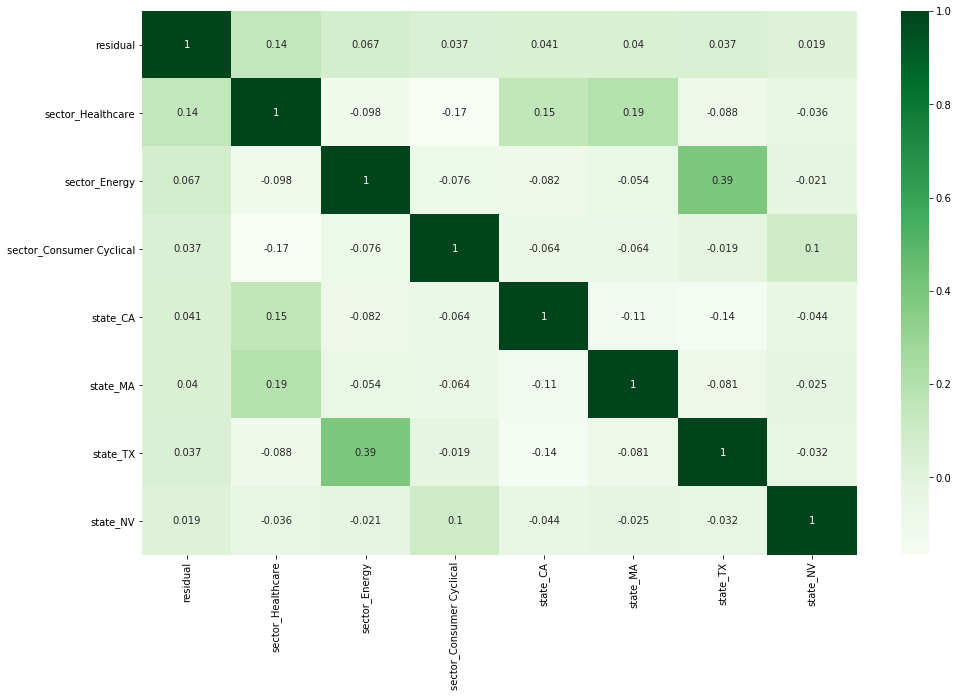

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

y_test['residual'] = (y_test['lightgbm_predict_80'] - y_test['spy_month_80']).abs()
corr = y_test[['residual', 'sector_Healthcare', 'sector_Energy', 'sector_Consumer Cyclical', 'state_CA', 'state_MA', 'state_TX', 'state_NV']].corr()
plt.figure(figsize=(16, 10))
ax = sns.heatmap(corr, cmap='Greens', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [17]:
y_train = stock_df.loc[stock_df.month <= '2018-05-01', 'month_60'].copy()

lightgbm_model = lgb.LGBMRegressor().fit(X_train, y_train)

y_test['lightgbm_predict_60'] = lightgbm_model.predict(X_test)

top50_60_df = pd.DataFrame(y_test.groupby('month')['lightgbm_predict_60'].nlargest(50).reset_index(level=1, drop=True))
pd.merge(y_test[['month', 'stock', 'lightgbm_predict_60', 'month_60']], top50_60_df, on = ['month', 'lightgbm_predict_60']).month_60.mean()

0.20334347345391623

In [18]:
y_train = stock_df.loc[stock_df.month <= '2018-05-01', 'month_80'].copy()

lightgbm_model = lgb.LGBMRegressor().fit(X_train, y_train)

top50_80_df = pd.DataFrame(y_test.groupby('month')['lightgbm_predict_80'].nlargest(50).reset_index(level=1, drop=True))
pd.merge(y_test[['month', 'stock', 'lightgbm_predict_80', 'month_80']], top50_80_df, on = ['month', 'lightgbm_predict_80']).month_80.mean()

0.2773501146803983

In [19]:
y_train = stock_df.loc[stock_df.month <= '2018-05-01', 'spy_month_120'].copy()

lightgbm_model = lgb.LGBMRegressor().fit(X_train, y_train)

y_test['lightgbm_predict_120'] = lightgbm_model.predict(X_test)

top50_120_df = pd.DataFrame(y_test.groupby('month')['lightgbm_predict_120'].nlargest(50).reset_index(level=1, drop=True))
pd.merge(y_test[['month', 'stock', 'lightgbm_predict_120', 'spy_month_120']], top50_120_df, on = ['month', 'lightgbm_predict_120']).spy_month_120.mean()

0.34535516491665225

In [20]:
boost = lightgbm_model.booster_

df_feature_importance = (
    pd.DataFrame({
        'feature': boost.feature_name(),
        'importance': boost.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

df_feature_importance.rename(columns={'feature':'Feature', 'importance':'Importance'}).head(10)

,Feature,Importance
0,Open,305
366,reportedEPS,119
367,estimatedEPS,119
1,month_-120,105
430,commonStockSharesOutstanding,94
368,surprise,60
437,researchAndDevelopment,54
428,retainedEarnings,51
359,spy_month_-120,51
369,surprisePercentage,46


In [21]:
pd.options.display.float_format = '{:.2%}'.format

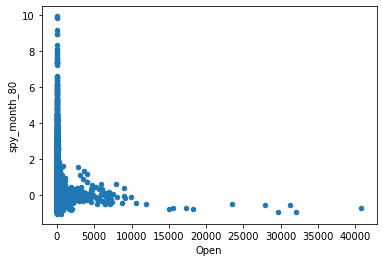

In [22]:
stock_df.plot.scatter(x = 'Open', y = 'spy_month_80')

In [23]:
stock_df['Open_binned'] = pd.qcut(stock_df['Open'], q=10)
pd.DataFrame(stock_df.groupby(['Open_binned']).agg({'spy_month_80' : 'mean'})).T

Open_binned,"(0.999, 5.07]","(5.07, 9.18]","(9.18, 13.37]","(13.37, 17.991]","(17.991, 23.672]","(23.672, 31.0]","(31.0, 40.951]","(40.951, 56.76]","(56.76, 89.624]","(89.624, 40800.0]"
spy_month_80,10.45%,2.66%,1.36%,0.38%,0.03%,-0.66%,-0.87%,-1.04%,-1.30%,-1.27%


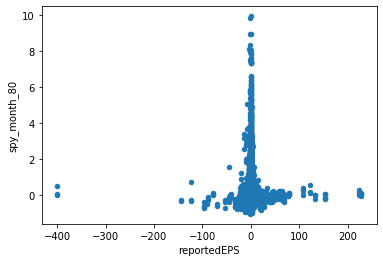

In [24]:
y_test.plot.scatter(x = 'reportedEPS', y = 'spy_month_80')

In [25]:
y_test['reportedEPS'] = y_test['reportedEPS'].astype(float)
y_test['reportedEPS_binned'] = pd.qcut(y_test['reportedEPS'], q=10)
pd.DataFrame(y_test.groupby(['reportedEPS_binned']).agg({'spy_month_80' : 'mean'})).T

reportedEPS_binned,"(-400.37399999999997, -0.4]","(-0.4, -0.09]","(-0.09, 0.06]","(0.06, 0.2]","(0.2, 0.35]","(0.35, 0.51]","(0.51, 0.71]","(0.71, 1.01]","(1.01, 1.6]","(1.6, 228.305]"
spy_month_80,3.57%,6.36%,4.81%,0.13%,-0.92%,-1.86%,-1.40%,-1.93%,-0.86%,-0.48%


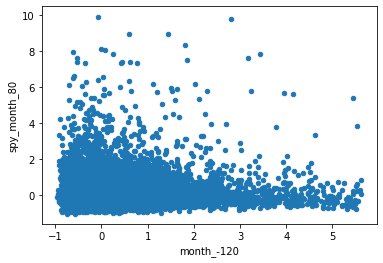

In [26]:
y_test.plot.scatter(x = 'month_-120', y = 'spy_month_80')

In [27]:
y_test['month_-120_binned'] = pd.qcut(y_test['month_-120'], q=10)
pd.DataFrame(y_test.groupby(['month_-120_binned']).agg({'spy_month_80' : 'mean'})).T

month_-120_binned,"(-0.957, -0.322]","(-0.322, -0.189]","(-0.189, -0.1]","(-0.1, -0.0293]","(-0.0293, 0.0331]","(0.0331, 0.0984]","(0.0984, 0.175]","(0.175, 0.291]","(0.291, 0.523]","(0.523, 5.618]"
spy_month_80,3.70%,-0.69%,-1.47%,-1.40%,-1.32%,-1.28%,-0.43%,0.79%,2.43%,7.35%


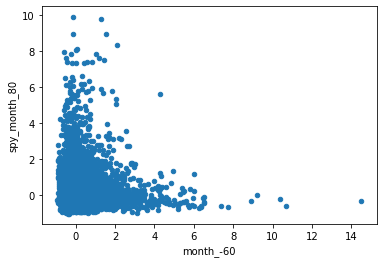

In [28]:
y_test.plot.scatter(x = 'month_-60', y = 'spy_month_80')

In [29]:
y_test['month_-60_binned'] = pd.qcut(y_test['month_-60'], q=10)
pd.DataFrame(y_test.groupby(['month_-60_binned']).agg({'spy_month_80' : 'mean'})).T

month_-60_binned,"(-0.939, -0.243]","(-0.243, -0.135]","(-0.135, -0.0679]","(-0.0679, -0.0179]","(-0.0179, 0.0265]","(0.0265, 0.0722]","(0.0722, 0.125]","(0.125, 0.199]","(0.199, 0.338]","(0.338, 14.5]"
spy_month_80,5.41%,-0.01%,-0.26%,-0.69%,-1.18%,-1.15%,-0.83%,-1.03%,0.87%,6.55%


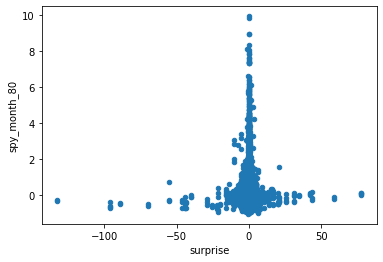

In [30]:
y_test['surprise'] = y_test['surprise'].astype(float)
y_test.plot.scatter(x = 'surprise', y = 'spy_month_80')

In [31]:
y_test['surprise_binned'] = pd.qcut(y_test['surprise'], q=10)
pd.DataFrame(y_test.groupby(['surprise_binned']).agg({'spy_month_80' : 'mean'})).T

surprise_binned,"(-132.58, -0.12]","(-0.12, -0.0296]","(-0.0296, 0.0]","(0.0, 0.0017]","(0.0017, 0.0186]","(0.0186, 0.04]","(0.04, 0.0711]","(0.0711, 0.126]","(0.126, 0.255]","(0.255, 77.6]"
spy_month_80,0.80%,-0.87%,0.19%,0.30%,-0.69%,-0.60%,0.75%,2.22%,2.29%,3.44%


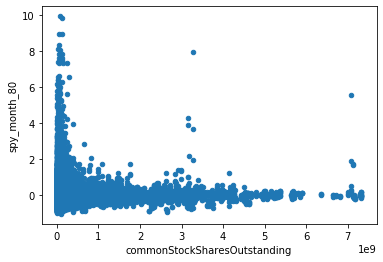

In [32]:
shares_df = y_test.loc[y_test.commonStockSharesOutstanding > 0]
shares_df = shares_df.loc[(shares_df['commonStockSharesOutstanding'] > shares_df['commonStockSharesOutstanding'].mean() - 3 * shares_df['commonStockSharesOutstanding'].std() ) & (shares_df['commonStockSharesOutstanding'] < shares_df['commonStockSharesOutstanding'].mean() + 3 * shares_df['commonStockSharesOutstanding'].std() )]
shares_df.plot.scatter(x = 'commonStockSharesOutstanding', y = 'spy_month_80')

In [33]:
shares_df['commonStockSharesOutstanding_binned'] = pd.qcut(shares_df['commonStockSharesOutstanding'], q=10)
pd.DataFrame(shares_df.groupby(['commonStockSharesOutstanding_binned']).agg({'spy_month_80' : 'mean'})).T

commonStockSharesOutstanding_binned,"(1995.999, 12061616.0]","(12061616.0, 21463278.0]","(21463278.0, 31495500.0]","(31495500.0, 43409552.0]","(43409552.0, 57903179.5]","(57903179.5, 81908558.0]","(81908558.0, 118992000.0]","(118992000.0, 198887286.0]","(198887286.0, 421000000.0]","(421000000.0, 7327000000.0]"
spy_month_80,-0.04%,0.43%,0.58%,1.93%,0.62%,1.59%,0.75%,1.76%,0.11%,-0.12%


In [34]:
stock_df.shape

(277648, 470)